# Classifying max vs regular custody level

## Initial classification

**Notebook Setup**

In [1]:
#!pip install bioinfokit

In [2]:
import sys
sys.path.append("../src")
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
#from heatmap import heatmap
import statsmodels.formula.api as smf
#import bioinfokit

In [4]:
plt.style.use('ggplot')

In [5]:
from math391.models.logit_models import LogitModelRunner
from math391.preprocessing import preprocess_for_logit
from math391.plotting import roc_plot

In [6]:
%matplotlib inline

from project import rf_models, preprocessing

df = pd.read_csv("../data/initial_custody_2017_gsprs.csv", low_memory=False)

df['high_ic_instit_adj'] = np.where(df['ic_institut_adj']>2, 1, 0)
df['ic_override_up'] = np.where(df['ic_ovride_cust_lvl']-df['ic_custdy_level']>0,1,0)
df['high_ic'] = np.where(df['ic_custdy_level']>4, 1, 0)


# preprocessing
data = preprocessing.preprocess_input_vars(df)
data = data[data.ic_custdy_level > 1]
data = data[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        #"ic_custdy_level",
        "prior_commits",
        "ic_institut_adj",
        "escape_hist_1",
        #"escape_hist_2",
        #"escape_hist_3",
        #"escape_hist_4",
        "escape_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed",
        #"high_ic_instit_adj",
        "high_ic"
    ]
]
data = data.dropna()

df_ic_all = data

In [7]:
df = pd.concat([df, pd.get_dummies(df.race, prefix="race").drop("race_W", axis=1)], axis=1)

#### Exploratory data analysis

In [7]:
df_ic_all['high_ic'].value_counts()

0    13764
1       51
Name: high_ic, dtype: int64

In [8]:
# This is to find if there is perfect separation
#max_secy = df_ic_all[df_ic_all['high_ic']==1]

In [9]:
#max_secy

In [10]:
count_hi = len(df_ic_all[df_ic_all['high_ic']==0])
count_lo = len(df_ic_all[df_ic_all['high_ic']==1])
pct_hi = count_hi/(count_hi+count_lo)
print("percentage of high lev is", pct_hi*100)
pct_lo = count_lo/(count_hi+count_lo)
print("percentage of low lev is", pct_lo*100)

percentage of high lev is 99.63083604777417
percentage of low lev is 0.3691639522258415


#### See how quantitative variables vary with custody level

In [11]:
df_ic_all.groupby('high_ic').mean()['prior_commits']

high_ic
0    3.282912
1    3.843137
Name: prior_commits, dtype: float64

In [12]:
df_ic_all.groupby('high_ic').mean()['off_1_gs_max']

high_ic
0    11.773394
1    13.431373
Name: off_1_gs_max, dtype: float64

In [13]:
df_ic_all.groupby('high_ic').mean()['off_1_prs_max']

high_ic
0    2.522922
1    2.725490
Name: off_1_prs_max, dtype: float64

In [14]:
df_ic_all.groupby('high_ic').mean()['ic_institut_adj']

high_ic
0    3.146178
1    4.098039
Name: ic_institut_adj, dtype: float64

####  See how quantitative variables vary with race_B

In [15]:
df_ic_all.groupby('race_B').mean()['ic_institut_adj']

race_B
0    2.949816
1    3.328127
Name: ic_institut_adj, dtype: float64

In [16]:
df_ic_all.groupby('race_B').mean()['off_1_prs_max']

race_B
0    2.401013
1    2.633169
Name: off_1_prs_max, dtype: float64

In [17]:
df_ic_all.groupby('race_B').mean()['off_1_gs_max']

race_B
0    11.151473
1    12.340184
Name: off_1_gs_max, dtype: float64

In [18]:
df_ic_all.groupby('race_B').mean()['prior_commits']

race_B
0    3.343002
1    3.233183
Name: prior_commits, dtype: float64

#### Visualizations

Text(0, 0.5, 'Count of people')

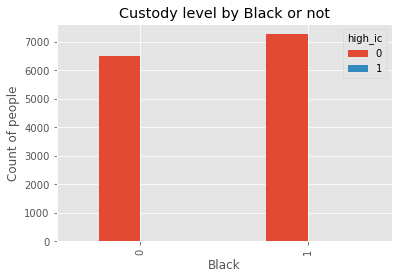

In [19]:
%matplotlib inline
pd.crosstab(df_ic_all.race_B,df_ic_all.high_ic).plot(kind='bar')
plt.title('Custody level by Black or not')
plt.xlabel('Black')
plt.ylabel('Count of people')

Text(0, 0.5, 'Proportion of people')

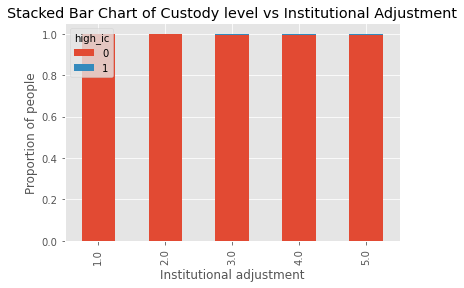

In [20]:
table=pd.crosstab(df_ic_all.ic_institut_adj,df_ic_all.high_ic)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Custody level vs Institutional Adjustment')
plt.xlabel('Institutional adjustment')
plt.ylabel('Proportion of people')

Text(0, 0.5, 'Proportion of people')

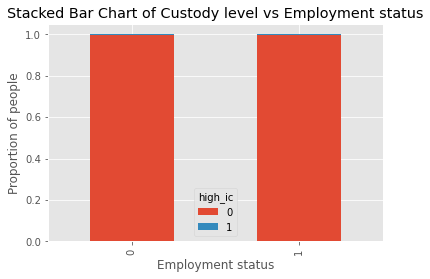

In [21]:
table=pd.crosstab(df_ic_all.employed,df_ic_all.high_ic)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Custody level vs Employment status')
plt.xlabel('Employment status')
plt.ylabel('Proportion of people')

Text(0, 0.5, 'Proportion of people')

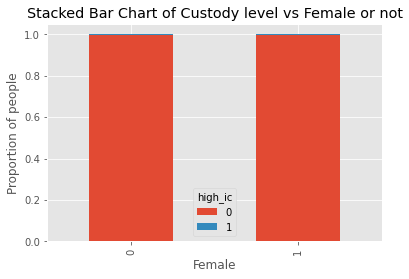

In [22]:
table=pd.crosstab(df_ic_all.gender_female,df_ic_all.high_ic)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Custody level vs Female or not')
plt.xlabel('Female')
plt.ylabel('Proportion of people')

### Building the full model with all features used by the PACT

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [9]:
data_final = df_ic_all

In [10]:
#We ommitted escape histories 2, 3 and 4 because they were highly correlated with escape history 1
#and because we want to know if they're frequent escapees or not, and not necessarily how many times

#We also ommitted some variables to avoid complete separation 

data_final_vars=data_final.columns.values.tolist()
yvars = ['high_ic']
Xvars = [i for i in data_final_vars if i not in yvars]
X = data_final.loc[:, data_final.columns != 'high_ic']
y = data_final.loc[:, data_final.columns == 'high_ic']
ll = ['age_gt_45',
 'ic_institut_adj',
 'escape_hist_1',
 #'escape_hist_2',
 #'escape_hist_3',
 #'escape_hist_4',
 'escape_hist_5',
 #'mrt_stat_DIV',
 #'mrt_stat_SEP',
 'mrt_stat_MAR',
 #'mrt_stat_WID',
 'employed']
ll.append('race_B')
#ll.append('race_A')
ll.append('race_H')
#ll.append('race_I')
#ll.append('race_O')
ll.append('off_1_gs_max')
ll.append('off_1_prs_max')
ll.append('prior_commits')
ll.append('age_lt_25')
ll.append('gender_female')
X = X[ll]


In [11]:
X.columns.values

array(['age_gt_45', 'ic_institut_adj', 'escape_hist_1', 'escape_hist_5',
       'mrt_stat_MAR', 'employed', 'race_B', 'race_H', 'off_1_gs_max',
       'off_1_prs_max', 'prior_commits', 'age_lt_25', 'gender_female'],
      dtype=object)

### Oversampling

In [12]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

X, y = os.fit_resample(X, y)

Optimization terminated successfully.
         Current function value: 0.411284
         Iterations 11
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.407     
Dependent Variable: high_ic          AIC:              22669.6490
Date:               2022-02-03 22:30 BIC:              22776.5475
No. Observations:   27528            Log-Likelihood:   -11322.   
Df Model:           12               LL-Null:          -19081.   
Df Residuals:       27515            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     11.0000                                      
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
age_gt_45        -1.9067   0.0871 -21.8868 0.0000 -2.0774 -1.7359
ic_institut_adj   0.3342   0.0129  25.8351 0.0000  0.3088  0.3595

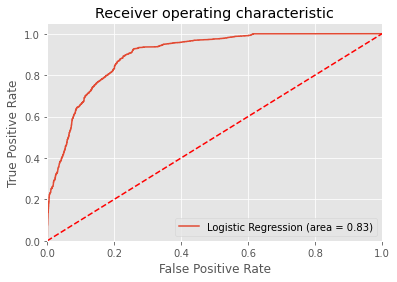

In [13]:
logit_model=sm.Logit(y,X)
result=logit_model.fit(max_iter=1000)
print(result.summary2())

model_odds = pd.DataFrame(np.exp(result.params), columns= ['OR'])
model_odds['z-value']= result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(result.conf_int())
print(model_odds)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train.values.ravel())
y_pred = logreg.predict(X_test)
print('\nAccuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("\n")
print(cm)
print("\n")
print(classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


#### Checking conditions on this model

In [45]:
# Absence of colinearity
Xc = np.asarray(X.corr())
print(Xc.min())
print(Xc[Xc < 1].max())

-0.3019999926410333
0.24411431723861104


In [46]:
X.corr()

,age_gt_45,ic_institut_adj,escape_hist_1,escape_hist_5,mrt_stat_MAR,employed,race_B,race_H,off_1_gs_max,off_1_prs_max,prior_commits,age_lt_25,gender_female
age_gt_45,1.000000,-0.226307,0.141081,-0.005675,0.149167,0.186787,-0.089366,-0.013282,-0.169635,0.031739,0.195913,-0.221147,0.037855
ic_institut_adj,-0.226307,1.000000,-0.240947,0.014366,-0.158483,-0.242475,-0.043861,-0.052795,0.106913,0.146917,0.076072,0.199438,-0.059146
escape_hist_1,0.141081,-0.240947,1.000000,-0.074168,0.123813,0.240970,-0.008567,0.046066,-0.107156,-0.148784,-0.241095,-0.000612,0.076517
escape_hist_5,-0.005675,0.014366,-0.074168,1.000000,0.023343,0.008231,0.003559,0.012700,-0.071455,-0.014351,0.023151,-0.002800,0.001925
mrt_stat_MAR,0.149167,-0.158483,0.123813,0.023343,1.000000,0.203426,-0.044905,0.026323,-0.066917,-0.011111,0.013637,-0.138745,0.040925
employed,0.186787,-0.242475,0.240970,0.008231,0.203426,1.000000,-0.085008,-0.002561,-0.124508,-0.057642,-0.017369,-0.180524,0.042598
race_B,-0.089366,-0.043861,-0.008567,0.003559,-0.044905,-0.085008,1.000000,-0.302000,0.148000,0.039516,-0.152081,0.050334,-0.035826
race_H,-0.013282,-0.052795,0.046066,0.012700,0.026323,-0.002561,-0.302000,1.000000,0.032750,-0.042944,-0.044295,0.001846,0.019402
off_1_gs_max,-0.169635,0.106913,-0.107156,-0.071455,-0.066917,-0.124508,0.148000,0.032750,1.000000,0.054581,-0.182235,0.225021,-0.054664
off_1_prs_max,0.031739,0.146917,-0.148784,-0.014351,-0.011111,-0.057642,0.039516,-0.042944,0.054581,1.000000,0.244114,-0.199543,-0.052429


#### Continuous IVs linearly related to log odss

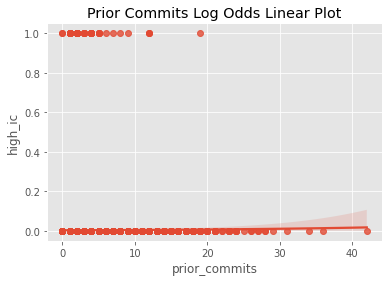

In [47]:
prior_commits = sns.regplot(x= 'prior_commits', y= 'high_ic', data=data_final, logistic= True).set_title("Prior Commits Log Odds Linear Plot")



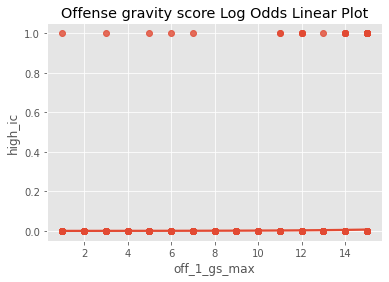

In [48]:
off_1_gs_max = sns.regplot(x= 'off_1_gs_max', y= 'high_ic', data=data_final, logistic= True).set_title("Offense gravity score Log Odds Linear Plot")


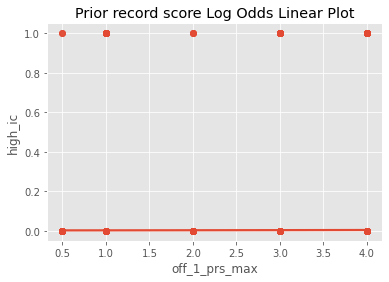

In [49]:
off_1_prs_max = sns.regplot(x= 'off_1_prs_max', y= 'high_ic', data=data_final, logistic= True).set_title("Prior record score Log Odds Linear Plot")


#### Outliers

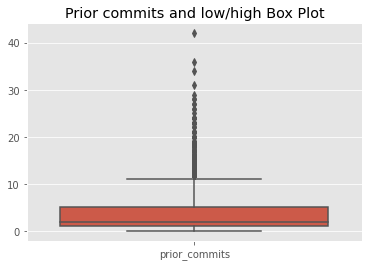

In [50]:
prior_commits_box = sns.boxplot(data= data_final[['prior_commits']]).set_title("Prior commits and low/high Box Plot")


/home/ncr006/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ncr006/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


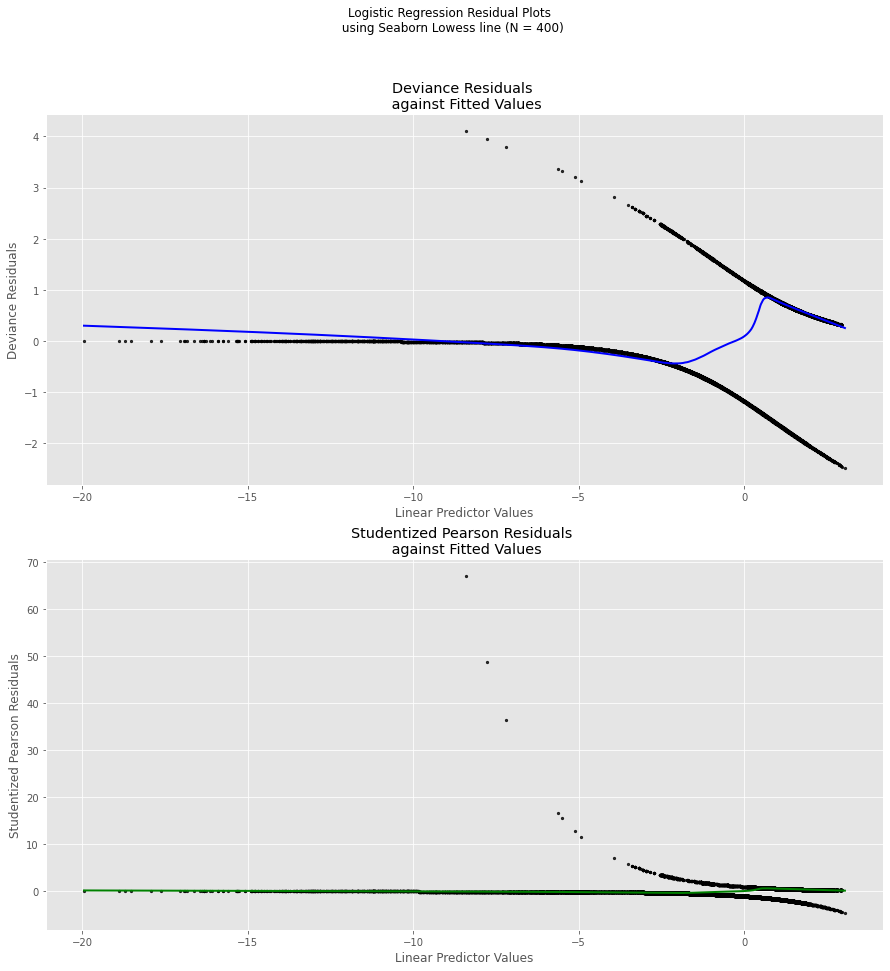

In [51]:
#### Residuals
## Plotting multiple plots same figure
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Residual Plots \n using Seaborn Lowess line (N = 400)")


# Deviance Residuals
sns.regplot(result.fittedvalues, result.resid_dev, ax= axL,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"b", "alpha":1, "lw":2}, lowess=True)

axL.set_title("Deviance Residuals \n against Fitted Values")
axL.set_xlabel("Linear Predictor Values")
axL.set_ylabel("Deviance Residuals")

# Studentized Pearson Residuals
sns.regplot(result.fittedvalues, result.resid_pearson, ax= axR,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"g", "alpha":1, "lw":2}, lowess=True)

axR.set_title("Studentized Pearson Residuals \n against Fitted Values")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Studentized Pearson Residuals")

plt.show()

### Feature selection

In [66]:
yvars = ['high_ic']
Xvars = ll #[i for i in data_final_vars if i not in yvars]
X = data_final.loc[:, data_final.columns != 'high_ic']
y = data_final.loc[:, data_final.columns == 'high_ic']
X = X[ll]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=500) # increase the number of iterations to get convergence
rfe = RFE(logreg, n_features_to_select=4, step=1)
rfe = rfe.fit(X, y.values.ravel())

In [68]:
zz= list(zip(Xvars,list(rfe.support_)))
features = [a for (a,b) in zz if b]
features

['escape_hist_1', 'escape_hist_5', 'employed', 'age_lt_25']

In [69]:
X.columns.values

array(['age_gt_45', 'ic_institut_adj', 'escape_hist_1', 'escape_hist_5',
       'mrt_stat_MAR', 'employed', 'race_B', 'race_H', 'off_1_gs_max',
       'off_1_prs_max', 'prior_commits', 'age_lt_25', 'gender_female'],
      dtype=object)

# SVM

In [21]:
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
classifier_df = SVC(kernel = 'linear' , random_state = 0)
classifier_df.fit(X_train,y_train)

#predicting test data result
y_pred = classifier_df.predict(X_test)


#setting up accuracy score

acc = accuracy_score(y_test,y_pred) *100
print("Accuracy for our dataset in predicting test data is : {:.2f}%".format(acc))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy for our dataset in predicting test data is : 79.55%
              precision    recall  f1-score   support

           0       0.88      0.69      0.77      4120
           1       0.74      0.90      0.82      4139

    accuracy                           0.80      8259
   macro avg       0.81      0.80      0.79      8259
weighted avg       0.81      0.80      0.79      8259



In [18]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [1,10,100], 'kernel': ['linear']}]
grid_search = GridSearchCV(estimator= classifier_df,
                          param_grid = parameters, scoring = 'accuracy',cv = 10)
grid_search = grid_search.fit(X_train, y_train)

accuracy = grid_search.best_score_ *100

print("Accuracy for our dataset with tuning is : {:.2f}%".format(accuracy) )

/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

KeyboardInterrupt: 

## Neural networks

In [22]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5,
                    hidden_layer_sizes=(14,), 
                    random_state=1, 
                    max_iter=10000)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test,y_pred) *100
print("Accuracy for our dataset in predicting test data is : {:.2f}%".format(acc))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy for our dataset in predicting test data is : 91.38%
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      4120
           1       0.89      0.94      0.92      4139

    accuracy                           0.91      8259
   macro avg       0.92      0.91      0.91      8259
weighted avg       0.92      0.91      0.91      8259



## Random forests

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 0)
clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test,y_pred) *100
print("Accuracy for our dataset in predicting test data is : {:.2f}%".format(acc))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


<ipython-input-23-8bc267bbfbcd>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Accuracy for our dataset in predicting test data is : 99.30%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4120
           1       0.99      0.99      0.99      4139

    accuracy                           0.99      8259
   macro avg       0.99      0.99      0.99      8259
weighted avg       0.99      0.99      0.99      8259

